# Precipitation Seasonal Climatology

In [1]:
# Import Python modules
import os, sys
import numpy as np
import pandas as  pd
import xarray as xr
# plotting
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib.gridspec import GridSpec
from mpl_toolkits.axes_grid1 import AxesGrid
import cartopy.crs as ccrs
from cartopy.mpl.geoaxes import GeoAxes
import seaborn as sns
import cmocean.cm as cmo
import cmocean
import cartopy.feature as cfeature
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter


from pathlib import Path

from IPython.display import Image, display

# Path to modules
sys.path.append('../modules')

# Import my modules
from plotter import draw_basemap
from plotter import make_cmap
from ar_funcs import preprocess_ar_area_subregions
import nclcmaps as nclc

### Set up paths

In [2]:
# Set up paths

path_to_data = '/home/nash/DATA/data/'                            # project data -- read only
path_to_out  = '/home/nash/DATA/repositories/AR_types/out/'       # output files (numerical results, intermediate datafiles) -- read & write
path_to_figs = '/home/nash/DATA/repositories/AR_types/figs/'      # figures


In [3]:
# Set a default font for all matplotlib text (can only set this ONCE; must restart kernel to change it)
rcParams['font.family'] = 'sans-serif'   # set the default font family to 'sans-serif'
rcParams['font.sans-serif'] = 'Arial'    # set the default sans-serif font to 'Arial'


## Data

### AR time series

In [4]:
# read netCDF with fraction of area AR covers each subregion
filename = path_to_data + 'CH1_generated_data/ar_catalog_ERAI_fraction_HASIAsubregions.nc'
f1 = xr.open_dataset(filename)

# Set dates
f1 = f1.sel(time=slice('2000-06-01', '2018-12-31'))

## Preprocess AR subregions - get dataframe of AR days based on area threshold
df = preprocess_ar_area_subregions(df=f1.to_dataframe(), thres=0.3)
# Show table
df.head()


,R01,R02,R03,ar,location
time,,,,,
2000-06-01,0.142857,0.000000,0.015306,0,NaN
2000-06-02,0.051020,0.005102,0.000000,0,NaN
2000-06-03,0.081633,0.051020,0.000000,0,NaN
2000-06-04,0.000000,0.025510,0.035714,0,NaN
2000-06-05,0.000000,0.020408,0.132653,0,NaN


### IMERG-PM

In [8]:
# Select lat/lon grid
lonmin = 60
lonmax = 110
latmin = 15
latmax =  50

def preprocess(ds):
    '''keep only the selected lats and lons'''
    return ds.sel(lat=slice(latmin, latmax), lon=slice(lonmin, lonmax))

filename_pattern1 = path_to_data + 'IMERGV06B/3B-DAY.MS.MRG.3IMERG.20*.nc4'
ds = xr.open_mfdataset(filename_pattern1, engine='netcdf4', concat_dim='time', combine='by_coords',
                      preprocess=preprocess)

print('ds size in GB {:0.2f}\n'.format(ds.nbytes / 1e9))
ds = ds.transpose('lat', 'lon', 'time')
ds = ds.sel(time=slice('2000-06-01', '2018-12-31'))
ds

# fname = '/home/sbarc/students/nash/data/IMERGV06B/climatology/filtered_daily_mean_clim_precipitationCal.nc'
# ds = xr.open_dataset(fname, engine='netcdf4')

# print('ds size in GB {:0.2f}\n'.format(ds.nbytes / 1e9))
# ds = ds.transpose('lat', 'lon', 'dayofyear')
# ds

ds size in GB 4.90



,Array,Chunk
Bytes,4.75 GB,700.00 kB
Shape,"(350, 500, 6788)","(350, 500, 1)"
Count,41788 Tasks,6788 Chunks
Type,float32,numpy.ndarray


In [9]:
clim_mean = ds.groupby('time.dayofyear').mean('time')
clim_mean.precipitationCal.max()

ds_new = xr.Dataset({'precip': (['time', 'lat', 'lon'], clim_mean.precipitationCal.values)},
                      coords={'lat': clim_mean.lat,
                        'lon': clim_mean.lon,
                        'time': pd.date_range('1980-01-01', '1980-12-31', freq='D')})

season_prec = ds_new.groupby('time.season').sum(dim='time')
season_prec

<xarray.Dataset>
Dimensions:  (lat: 350, lon: 500, season: 4)
Coordinates:
  * lon      (lon) float32 60.05 60.150005 60.249996 ... 109.85002 109.95
  * lat      (lat) float32 15.05 15.149999 15.250005 ... 49.850002 49.95001
  * season   (season) object 'DJF' 'JJA' 'MAM' 'SON'
Data variables:
    precip   (season, lat, lon) float32 7.7676067 8.315987 ... 74.012955 74.9898

### Select data subset

In [10]:
# Add AR time series to era5; set as coordinate variables
ds['ar'] = ('time', df.ar)
ds = ds.set_coords('ar')

ds['location'] = ('time', df.location)
ds = ds.set_coords('location')

# print dataset
print(ds)

<xarray.Dataset>
Dimensions:           (lat: 350, lon: 500, time: 6788)
Coordinates:
  * lon               (lon) float32 60.05 60.150005 ... 109.85002 109.95
  * lat               (lat) float32 15.05 15.149999 ... 49.850002 49.95001
  * time              (time) object 2000-06-01 00:00:00 ... 2018-12-31 00:00:00
    ar                (time) int64 0 0 0 0 0 0 0 1 1 0 0 ... 0 0 0 0 0 0 0 0 0 0
    location          (time) object nan nan nan nan nan ... nan nan nan nan nan
Data variables:
    precipitationCal  (lat, lon, time) float32 dask.array<chunksize=(350, 500, 1), meta=np.ndarray>
Attributes:
    BeginDate:       2000-06-01
    BeginTime:       00:00:00.000Z
    EndDate:         2000-06-01
    EndTime:         23:59:59.999Z
    FileHeader:      StartGranuleDateTime=2000-06-01T00:00:00.000Z;\nStopGran...
    InputPointer:    3B-HHR.MS.MRG.3IMERG.20000601-S000000-E002959.0000.V06B....
    title:           GPM IMERG Final Precipitation L3 1 day 0.1 degree x 0.1 ...
    DOI:             

In [11]:
# Trim date range
start_date = '2000-12-01'
end_date = '2018-02-28'
idx = slice(start_date, end_date)
ds = ds.sel(time=idx)

# Select DJF months
idx = (ds.time.dt.month >= 12) | (ds.time.dt.month <= 2)
ds = ds.sel(time=idx)

# Select AR days
idx = (ds.ar >= 1)
ds_ar = ds.sel(time=idx)

# print results
print(ds_ar)

<xarray.Dataset>
Dimensions:           (lat: 350, lon: 500, time: 164)
Coordinates:
  * lon               (lon) float32 60.05 60.150005 ... 109.85002 109.95
  * lat               (lat) float32 15.05 15.149999 ... 49.850002 49.95001
  * time              (time) object 2000-12-16 00:00:00 ... 2018-02-26 00:00:00
    ar                (time) int64 1 1 1 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1 1 1
    location          (time) object 'R01' 'R02/R03' 'R03' ... 'R02' 'R01' 'R01'
Data variables:
    precipitationCal  (lat, lon, time) float32 dask.array<chunksize=(350, 500, 1), meta=np.ndarray>
Attributes:
    BeginDate:       2000-06-01
    BeginTime:       00:00:00.000Z
    EndDate:         2000-06-01
    EndTime:         23:59:59.999Z
    FileHeader:      StartGranuleDateTime=2000-06-01T00:00:00.000Z;\nStopGran...
    InputPointer:    3B-HHR.MS.MRG.3IMERG.20000601-S000000-E002959.0000.V06B....
    title:           GPM IMERG Final Precipitation L3 1 day 0.1 degree x 0.1 ...
    DOI:             1

## Calculate climatology

In [12]:
# calculate seasonal totals
ds_ssn_sum = ds.resample(time='QS-DEC').sum()
ds_ar_ssn_sum = ds_ar.resample(time='QS-DEC').sum()                                 
# calculate average of seasonal totals
ds_clim = ds_ssn_sum.mean(dim='time')
ds_ar_clim = ds_ar_ssn_sum.mean(dim='time') 

# Mean prec of AR days in DJF
ds_ar_clim_day = ds_ar.mean(dim='time')
ds_clim_day = ds.mean(dim='time')


## Create figure

In [14]:
ds_clim

<xarray.Dataset>
Dimensions:           (lat: 350, lon: 500)
Coordinates:
  * lon               (lon) float32 60.05 60.150005 ... 109.85002 109.95
  * lat               (lat) float32 15.05 15.149999 ... 49.850002 49.95001
Data variables:
    precipitationCal  (lat, lon) float32 dask.array<chunksize=(350, 500), meta=np.ndarray>

In [16]:
# Data for plotting
lons = ds_clim.lon.values
lats = ds_clim.lat.values

prec_frac = (ds_ar_clim.precipitationCal.values/ds_clim.precipitationCal.values)*100.
std_dev_ar = ds_ar_ssn_sum.std(dim='time')
data = [ds_clim.precipitationCal.values, prec_frac, std_dev_ar.precipitationCal.values]
print(data[0].min(), data[0].max(), data[0].mean())
print(data[2].min(), data[2].max(), data[2].mean())
# Set up projection
mapcrs = ccrs.PlateCarree()
datacrs = ccrs.PlateCarree()

# Set tick/grid locations
dx = np.arange(lonmin,lonmax+20,20)
dy = np.arange(latmin,latmax+20,20)

# # set seaborn style
# sns.set()
# sns.set_style("ticks", {'patch.force_edgecolor':False})
plt_labels = ['Avg DJF Prec Totals', 'Avg DJF Prec Totals - comp', 'Avg DJF AR Prec Totals']
plt_labels = ['Avg DJF Prec Totals', 'AR Fraction of DJF Prec', 'Std. Dev. of AR DJF Prec']

0.014574745 739.9689 42.157898
5.1100968e-05 145.77766 9.036185


In [17]:
# clevs = np.arange(100., 2600., 100)
clevs = np.arange(25., 650., 25)
clevs

cmap_data = [
             (30, 60, 255), # dark blue 100-200
             (0, 160, 255), # light blue 200-300
             (0, 200, 200), # lighter blue 300-400
             (0, 210, 140), # teal 400-500
             (0, 220, 0), # green 500-600
             (160, 230, 50), #light green 600-700
             (160, 230, 50), #light green 700-800
             (230, 220, 50), # yellow 800-900
             (230, 220, 50), # yellow 900-1000
             (230, 175, 45), # light orange 1000-1100
             (230, 175, 45), # light orange 1100-1200
             (230, 175, 45), # light orange 1200-1300
             (230, 175, 45), # light orange 1300-1400
             (230, 175, 45), # light orange 1400-1500
             (240, 130, 40), # dark orange 1500-1600
             (240, 130, 40), # dark orange 1600-1700
             (240, 130, 40), # dark orange 1700-1800
             (240, 130, 40), # dark orange 1800-1900
             (240, 130, 40), # dark orange 1900-2000
             (250, 60, 60), # light red 2000-2100
             (250, 60, 60), # light red 2100-2200
             (250, 60, 60), # light red 2200-2300
             (250, 60, 60), # light red 2300-2400
             (250, 60, 60) # light red 2400-2500
#              (240, 0, 130)
            ]

my_cmap = make_cmap(cmap_data, bit=True)

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


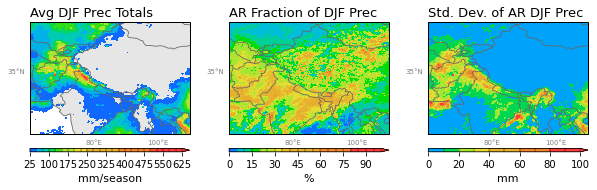

In [18]:
# Create figure
fig = plt.figure(figsize=(10,11))
nrows = 1
ncols = len(data)

# Set up Axes Grid
axes_class = (GeoAxes,dict(map_projection=mapcrs))
axgr = AxesGrid(fig, 111, axes_class=axes_class,
                nrows_ncols=(nrows, ncols), axes_pad = 0.55,
                cbar_location='bottom', cbar_mode='each',
                cbar_pad=0.2, cbar_size='3%',label_mode='')

# cmap = nclc.cmap('WhiteBlueGreenYellowRed')
cmap=my_cmap

clevs_list = [clevs, np.arange(0,105,5), np.arange(0,110,10)]
cbar_label = ['mm/season', '%', 'mm']

# Loop for drawing each plot
for k, ax in enumerate(axgr):
    ax = draw_basemap(ax, extent=[lonmin,lonmax,latmin,latmax], xticks=dx, yticks=dy)
    
    # Precip (filled contour)
#     clevs = np.arange(2,252,25)
    cf = ax.contourf(lons, lats, data[k], transform=datacrs,
                    levels=clevs_list[k],cmap=cmap, extend='max')
    
    # Subtitles
    ax.set_title(plt_labels[k], loc='left', fontsize=13)

    
    # Colorbar (each)
    cb = fig.colorbar(cf, axgr.cbar_axes[k], orientation='horizontal', drawedges=True)
    cb.set_label(cbar_label[k], fontsize=11)
    cb.ax.tick_params(labelsize=10)
    
# Save figure
filepath = path_to_figs + 'gpm_prec_clim_djf' + '.png'
plt.savefig(filepath, dpi=150, bbox_inches='tight')

# Show
plt.show()

In [19]:
# Data for plotting
lons = ds_clim.lon.values
lats = ds_clim.lat.values

prec_frac = (ds_ar_clim_day.precipitationCal.values/ds_clim_day.precipitationCal.values)*100.
std_dev_ar = ds_ar.std(dim='time')
data = [ds_clim_day.precipitationCal.values, ds_ar_clim_day.precipitationCal.values, std_dev_ar.precipitationCal.values]
for i in range(len(data)):
    print(data[i].min(), data[i].max(), data[i].mean())

# Set up projection
mapcrs = ccrs.PlateCarree()
datacrs = ccrs.PlateCarree()

# Set tick/grid locations
dx = np.arange(lonmin,lonmax+20,20)
dy = np.arange(latmin,latmax+20,20)

# # set seaborn style
# sns.set()
# sns.set_style("ticks", {'patch.force_edgecolor':False})
plt_labels = ['Avg DJF Prec Avg', 'AR Fraction of DJF Prec', 'Std. Dev. of AR DJF Prec']

0.00016154273 8.201625 0.46726736
1.3602956e-06 10.553652 0.83382285
1.7367092e-05 38.783005 2.5915878


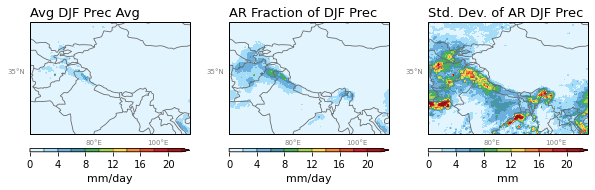

In [20]:
# Create figure
fig = plt.figure(figsize=(10,11))
nrows = 1
ncols = len(data)

# Set up Axes Grid
axes_class = (GeoAxes,dict(map_projection=mapcrs))
axgr = AxesGrid(fig, 111, axes_class=axes_class,
                nrows_ncols=(nrows, ncols), axes_pad = 0.55,
                cbar_location='bottom', cbar_mode='each',
                cbar_pad=0.2, cbar_size='3%',label_mode='')

cmap = nclc.cmap('WhiteBlueGreenYellowRed')
# cmap=my_cmap

clevs_list = [np.arange(0,24,2), np.arange(0,24,2), np.arange(0,24,2)]
cbar_label = ['mm/day', 'mm/day', 'mm']

# Loop for drawing each plot
for k, ax in enumerate(axgr):
    ax = draw_basemap(ax, extent=[lonmin,lonmax,latmin,latmax], xticks=dx, yticks=dy)
    
    # Precip (filled contour)
#     clevs = np.arange(2,252,25)
    cf = ax.contourf(lons, lats, data[k], transform=datacrs,
                    levels=clevs_list[k],cmap=cmap, extend='max')
    
    # Subtitles
    ax.set_title(plt_labels[k], loc='left', fontsize=13)

    
    # Colorbar (each)
    cb = fig.colorbar(cf, axgr.cbar_axes[k], orientation='horizontal', drawedges=True)
    cb.set_label(cbar_label[k], fontsize=11)
    cb.ax.tick_params(labelsize=10)
    
# Save figure
filepath = path_to_figs + 'gpm_prec_clim_djf_daily' + '.png'
plt.savefig(filepath, dpi=150, bbox_inches='tight')

# Show
plt.show()

In [ ]:
# Create figure
fig = plt.figure(figsize=(6,6))

# Add plot axes and draw basemap
ax = fig.add_subplot(111, projection=mapcrs)
#ax = draw_basemap(ax, extent=[lonmin,lonmax,latmin,latmax], xticks=dx, yticks=dy)

ax = draw_basemap(ax, extent=[lonmin,lonmax,latmin,latmax], xticks=dx, yticks=dy)

# prec (filled contour)
clevs = np.arange(2,22,2)
cf = ax.contourf(lons, lats, data, transform=datacrs, extend='max',
                levels=clevs, cmap=cmo.rain)


# Colorbar 
cb = fig.colorbar(cf, orientation='horizontal', drawedges=True, pad=0.04, aspect=25)
cb.set_label('prec (mm day$^{-1}$)', fontsize=11)
cb.ax.tick_params(labelsize=10)

# Title
ax.set_title('Precipitation (Dec-Feb 1979-2018)', loc='center', fontsize=13)

# show figure
filepath = path_to_figs + 'prec_clim_djf' + '.png'
plt.savefig(filepath, bbox_inches='tight', dpi=200)
plt.show()


In [ ]:
# Data for plotting
lons = era_ar_clim.lon.values
lats = era_ar_clim.lat.values
data = era_ar_clim.prec.values
print(data.min(), data.max())

In [ ]:
# Create figure
fig = plt.figure(figsize=(6,6))

# Add plot axes and draw basemap
ax = fig.add_subplot(111, projection=mapcrs)
#ax = draw_basemap(ax, extent=[lonmin,lonmax,latmin,latmax], xticks=dx, yticks=dy)

ax = draw_basemap(ax, extent=[lonmin,lonmax,latmin,latmax], xticks=dx, yticks=dy)

# prec (filled contour)
clevs = np.arange(2,22,2)
cf = ax.contourf(lons, lats, data, transform=datacrs, extend='max',
                levels=clevs, cmap=cmo.rain)


# Colorbar 
cb = fig.colorbar(cf, orientation='horizontal', drawedges=True, pad=0.04, aspect=25)
cb.set_label('prec (mm day$^{-1}$)', fontsize=11)
cb.ax.tick_params(labelsize=10)

# Title
ax.set_title('AR Days (Dec-Feb 1979-2018)', loc='center', fontsize=13)

# show figure
filepath = path_to_figs + 'prec_ar_clim_djf' + '.png'
plt.savefig(filepath, bbox_inches='tight', dpi=200)
plt.show()
